In [1]:
# Validation of the steady-state simulation - Case 1: MLP with Optimal settings
## Optimal Settings are like below:
# 1. Train/Validation/Test dataset ratio = 0.7/0.2/0.1
# 2. Cd scaling -> replaced as normalization for both Cl and Cd
# 3. Seperate the ML models into the two models, a model only for Cl and the other for Cd
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from scipy import interpolate
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_units=256 # Number of units in the hidden layer of the MLP network
n_layers=5
input_size = 110 + 3 # Size of input for the network (110 coefficients and 3 other parameters, time, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate = 0.1 # Defines the ratio of test dataset
val_rate = 0.2 # Defines the ratio of validation dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 200 # Mini-batch size
l2_regularizer=1e-07

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
thickness = 0.02 * h # Thickness of the Gurney flaps
beta = np.linspace(30, 90, 5).reshape((5,1))

h = h[-1]
beta = beta[-1]

In [5]:
h = h.reshape((-1,1))
thickness = thickness.reshape((-1,1))

In [6]:
t_interval = 0.001
t_len = int((11-10) / t_interval)

n_beta = len(beta)# Number of the Gurney flap inclination
n_h = len(h) # Number of the height of the Gurney flaps
n_cases = n_data * t_len # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating Input dataset
# Defining time as input

main_directory = 'D:\\VAWT_data'
cm_dir = main_directory + "\\blade_1_cm_data"
cm_list = os.listdir(cm_dir)
os.chdir(cm_dir)

In [8]:
cm_target = [file for file in cm_list if file.endswith('.csv')]
cm_target = sorted(cm_target, key=lambda s: int(re.search(r'\d+',s).group()))
cm_target = [cm_target[-8],]

In [9]:
cm_target

['case15cm_blade1.csv']

In [10]:
### Create input and output data
### This function is the main framework where data are reordered with respect to the shape the NNs require.
### Each input features are made by calling the corresponding functions, which generate the data,
### e.g., time, cm, h, beta, coordinates of airfoil and Gurney flaps, etc.
def genereate_input_output(cm_target, n_beta, t_len, normalize:bool=False):
    
    input_time_cm = time_and_cm(cm_target)
    t = input_time_cm[:,0].reshape((-1, 1))
    cm = input_time_cm[:,1].reshape((-1, 1))
    
    hh = generate_h(n_beta, t_len, normalize)
    bb = generate_beta(n_beta, t_len, normalize)
#     total_coords = generate_coordinates(n_cases)
    
    # Concatenate data for input dataset
    #x = np.hstack((t, hh, bb, total_coords))
    #x = np.hstack((t, total_coords))
    x = t
    #x = np.hstack((t, hh, bb))
    
    # Generating output dataset (depending on whether the data be normalized or not)
    if normalize==True:
        y = (cm-np.min(cm))/(np.max(cm)-np.min(cm))
    else:
        y = cm
    print("Dimension - x: ", x.shape)
    print("Dimension - y: ", y.shape)
    
    return x, y, t, cm

In [11]:
## Creating time for input, and Cm (moment coefficient) for output
def time_and_cm(cm_target):
    cm_df = pd.DataFrame()
    for i, file in enumerate(cm_target):
        df = pd.DataFrame()
        
        data = pd.read_csv(file, header=None)
        df = pd.concat([df, data], axis=0)
        
        time = df.iloc[:,0].values
        cm = df.iloc[:,1].values
        
        time_beUsed = time[np.where(np.logical_and(time>=10, time<11))]
        cm_beUsed = cm[np.where(np.logical_and(time>=10, time<11))]
        
        # Handle the time that is duplicated because of digits
        # Also, outliers are regulated at the second conditional statement.
        time_beUsed = handler_time(time_beUsed)
        cm_beUsed = handler_cm(cm_beUsed)
        
        linear_func = interpolate.interp1d(time_beUsed, cm_beUsed,
                                           bounds_error=False,kind='quadratic',
                                           fill_value='extrapolate')
        time_interp = np.arange(10, 11, t_interval).reshape((-1,1))
        cm_interp=linear_func(time_interp).reshape((-1,1))
        
        cm_df = pd.concat([cm_df, pd.DataFrame(np.hstack((time_interp, cm_interp)))], axis=0)
    
    input_time_cm = cm_df.iloc[:,:].values
    print("Dimension - time and Cm: ", input_time_cm.shape)
    return input_time_cm

In [12]:
# Handling duplicated time value
def handler_time(time_beUsed):
    for i in range(len(time_beUsed)):
        if time_beUsed[i]==time_beUsed[i-1]:
            time_beUsed[i] += 0.0005
            
    return time_beUsed

In [13]:
# Handling outlier, (if there are)
def handler_cm(cm_beUsed):
    period = int(len(cm_beUsed) / 5)
    for i in range(len(cm_beUsed)):
        if np.abs(cm_beUsed[i]-cm_beUsed[i-1])>0.3:
            cm_beUsed[i-1] = cm_beUsed[i-1 + period]
            
    return cm_beUsed

In [14]:
## Defining beta, the Gurney flap inclination
## In case of mere NACA0018, the bb in those indexes are considered as zero.
def generate_beta(n_beta=n_beta, t_len=t_len, normalize=True):

#     beta_0 = np.zeros((t_len,1)) # Values for sheer NACA0018
    b_ = np.ones((t_len,1)) # Template for the inclination for a single h and single beta
    bb_imp = np.zeros((t_len*n_beta,1))

    for j in range(n_beta):
        b_imp = b_ * beta[j]
        bb_imp[t_len*j:t_len*(j+1),:] = b_imp[:,:]

    bb_imp = bb_imp.reshape((-1,1))
    bb = bb_imp
    if normalize==True:
        bb = bb / np.max(beta)
    
    print("Dimension - inclination(beta): ", bb.shape)

    return bb

In [15]:
## Defining the Gurney flap height
## In case of mere NACA0018, the hh in those indexes are considered as zero.
def generate_h(n_beta=n_beta, t_len=t_len, normalize:bool=True):
    #hh = np.concatenate((np.zeros(t_len), h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len), h[2]*np.ones(n_beta*t_len)))
    hh = h[0]*np.ones(n_beta*t_len)
    hh = hh.reshape((-1,1))
    
    if normalize==True:
        hh = hh / np.max(h)
    
    print("Dimension - heights of Gurney flaps: ", hh.shape)
    return hh

In [16]:
## Generates coordinate data of NACA0018 airfoil and Gurney flaps
def generate_coordinates(n_cases):
    origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

    csv_file_name = origin_coord + '\\airfoilOut15.txt'
    data = pd.read_csv(csv_file_name, header=None)
    
    baseline_coord_high = data.iloc[0,:]
    baseline_coord_low = data.iloc[1,:]
    baseline_coord = np.hstack((np.flip(baseline_coord_high), baseline_coord_low)).reshape((1,-1))
    airfoil_coord = np.repeat(baseline_coord, n_cases, axis=0)
    print("Dimension - airfoil coordinates: ", airfoil_coord.shape)
    
    flap_coords= coord_with_flaps(n_cases)
    total_coords = np.hstack((airfoil_coord, flap_coords))
    
    print("Dimension - total coordinates: ", total_coords.shape)
    
    return total_coords

In [17]:
# Generating data of Gurney flap coordinates
def coord_with_flaps(n_cases):
    flap_left = np.zeros((15,5))
    flap_right = np.zeros((15,5))

    for i in range(n_h):
        # Defining coordinates of the flaps with respect to beta=90 degree.
        yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
        xRight = 0.5*np.ones((5,1))

        for j in range(n_beta):
            betaValue = beta[j]

            # Rotating transformation
            rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                     [np.sin(90-betaValue), np.cos(90-betaValue)]])
            rotateTransf = rotateTransf.reshape((2,2))

            LeftImp = np.hstack((xLeft-0.5, yLeft))
            RightImp = np.hstack((xRight-0.5, yRight))

            rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
            rotatedFlapRight = rotateTransf @ RightImp.T

            # All we need is the y-coordinates of the flaps
            flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
            flap_right[5*i+j,:] = rotatedFlapRight[1,:]
    
    flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
    flap_coords2 = np.zeros((n_cases, 10))
    
    for i in range(t_len, n_cases):
        flap_coords2[i,:] = flap_coords[i%15,:]
    print("Dimension - coord with flaps: ", flap_coords2.shape)
    
    return flap_coords2

In [18]:
# Generating x, y and cm (for denormalizing)
x, y, t, cm = genereate_input_output(cm_target, n_beta, t_len, normalize=True)

Dimension - time and Cm:  (1000, 2)
Dimension - heights of Gurney flaps:  (1000, 1)
Dimension - inclination(beta):  (1000, 1)
Dimension - x:  (1000, 1)
Dimension - y:  (1000, 1)


In [19]:
x[:,0] -= 10
x[:,0] /= 5

In [20]:
def dataset_split(x, y, cm, test_rate, random_state=1, **kwargs):
    if kwargs.get('validation')==True:
        val_rate = kwargs.get('val_rate')
        x_all, x_test, y_all, y_test, cm_all, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        x_train, x_val, y_train, y_val, cm_train, cm_val = train_test_split(x_all, y_all, cm_all, test_size=val_rate/(1-test_rate),
                                                                            random_state=kwargs.get('random_state'))
        return x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test
    else:
        x_train, x_test, y_train, y_test, cm_train, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        return x_train, x_test, y_train, y_test, cm_train, cm_test

In [21]:
x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test = dataset_split(x, y, cm,
                                                                                          test_rate, val_rate=val_rate,
                                                                                          validation=True, random_state=50)

In [22]:
def make_mlp_model(num_layer:int = 1): # This function can only generate model with at least 3 hidden layers
    input_data = tf.keras.Input(shape=1)

    # The first hidden layer
    x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1',
                                #kernel_initializer='he_uniform',
                                kernel_regularizer=regularizers.l2(l2_regularizer))(input_data)
    
    # The other hidden layers, which will be placed between the first hidden layer and the last hidden layer.
    # The number of layers that the user desires is input of this function.
    for i in range(0, num_layer-2):
        x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % (i+2),
                                     #kernel_initializer='he_uniform',
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)
    
    # The last hidden layer
    x_fc_final = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % num_layer,
                                       #kernel_initializer='he_uniform',
                                       kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)

    # The output layer
    output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc_final)
    
    # MLP(FC layer)-based
    model = tf.keras.Model(input_data, output_data)
    
    return model

In [23]:
model = make_mlp_model(num_layer=n_layers)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 fc1 (Dense)                 (None, 256)               512       
                                                                 
 fc2 (Dense)                 (None, 256)               65792     
                                                                 
 fc3 (Dense)                 (None, 256)               65792     
                                                                 
 fc4 (Dense)                 (None, 256)               65792     
                                                                 
 fc5 (Dense)                 (None, 256)               65792     
                                                                 
 outputLayer (Dense)         (None, 1)                 257   

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [25]:
model_directory = "D:\\TrainedModels\\20221230\\Case13_WithoutParameters"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [26]:
ckpt_name = model_directory + "20221230unsteadyPrediction_MLP_Case13_WithoutParameters_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" +str(n_layers)+"layers_"+ str(n_units) +"units_checkpoint.h5"

ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, min_delta=1e-05,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=100, factor=0.5,
                                          min_delta = 1e-05, min_lr=1e-05, verbose=1)

In [27]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
VALIDATION_STEPS = len(x_val)//batch_size

In [28]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, batch_size=batch_size,
                    validation_data=[x_val, y_val],
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, ckpt, rp])
end = datetime.datetime.now()

Epoch 1/10000
1/3 [=========>....................] - ETA: 2s - loss: 0.1792 - rmse: 0.4232
Epoch 1: val_loss improved from inf to 0.18935, saving model to D:\TrainedModels\20221230\Case13_WithoutParameters20221230unsteadyPrediction_MLP_Case13_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 2s 116ms/step - loss: 0.2076 - rmse: 0.4555 - val_loss: 0.1894 - val_rmse: 0.4350 - lr: 1.0000e-04
Epoch 2/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.2511 - rmse: 0.5010
Epoch 2: val_loss improved from 0.18935 to 0.18269, saving model to D:\TrainedModels\20221230\Case13_WithoutParameters20221230unsteadyPrediction_MLP_Case13_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 41ms/step - loss: 0.2132 - rmse: 0.4616 - val_loss: 0.1827 - val_rmse: 0.4273 - lr: 1.0000e-04
Epoch 3/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.1932 - rmse: 0.4394
Epoch 3: val_l

1/3 [=========>....................] - ETA: 0s - loss: 0.0671 - rmse: 0.2589
Epoch 21: val_loss improved from 0.06556 to 0.06507, saving model to D:\TrainedModels\20221230\Case13_WithoutParameters20221230unsteadyPrediction_MLP_Case13_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 40ms/step - loss: 0.0715 - rmse: 0.2672 - val_loss: 0.0651 - val_rmse: 0.2549 - lr: 1.0000e-04
Epoch 22/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0780 - rmse: 0.2792
Epoch 22: val_loss improved from 0.06507 to 0.06414, saving model to D:\TrainedModels\20221230\Case13_WithoutParameters20221230unsteadyPrediction_MLP_Case13_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 41ms/step - loss: 0.0714 - rmse: 0.2671 - val_loss: 0.0641 - val_rmse: 0.2531 - lr: 1.0000e-04
Epoch 23/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0804 - rmse: 0.2834
Epoch 23: val_loss im

Epoch 40/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0692 - rmse: 0.2628
Epoch 40: val_loss improved from 0.06085 to 0.06061, saving model to D:\TrainedModels\20221230\Case13_WithoutParameters20221230unsteadyPrediction_MLP_Case13_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 41ms/step - loss: 0.0663 - rmse: 0.2573 - val_loss: 0.0606 - val_rmse: 0.2460 - lr: 1.0000e-04
Epoch 41/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0570 - rmse: 0.2385
Epoch 41: val_loss improved from 0.06061 to 0.06026, saving model to D:\TrainedModels\20221230\Case13_WithoutParameters20221230unsteadyPrediction_MLP_Case13_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0631 - rmse: 0.2511 - val_loss: 0.0603 - val_rmse: 0.2453 - lr: 1.0000e-04
Epoch 42/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0836 - rmse: 0.2890
Epoch 

1/3 [=========>....................] - ETA: 0s - loss: 0.0614 - rmse: 0.2476
Epoch 58: val_loss improved from 0.05634 to 0.05602, saving model to D:\TrainedModels\20221230\Case13_WithoutParameters20221230unsteadyPrediction_MLP_Case13_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0597 - rmse: 0.2441 - val_loss: 0.0560 - val_rmse: 0.2365 - lr: 1.0000e-04
Epoch 59/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0629 - rmse: 0.2505
Epoch 59: val_loss improved from 0.05602 to 0.05570, saving model to D:\TrainedModels\20221230\Case13_WithoutParameters20221230unsteadyPrediction_MLP_Case13_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0562 - rmse: 0.2369 - val_loss: 0.0557 - val_rmse: 0.2358 - lr: 1.0000e-04
Epoch 60/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0640 - rmse: 0.2527
Epoch 60: val_loss im

1/3 [=========>....................] - ETA: 0s - loss: 0.0571 - rmse: 0.2388
Epoch 76: val_loss improved from 0.05026 to 0.04965, saving model to D:\TrainedModels\20221230\Case13_WithoutParameters20221230unsteadyPrediction_MLP_Case13_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0534 - rmse: 0.2309 - val_loss: 0.0496 - val_rmse: 0.2226 - lr: 1.0000e-04
Epoch 77/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0553 - rmse: 0.2349
Epoch 77: val_loss improved from 0.04965 to 0.04892, saving model to D:\TrainedModels\20221230\Case13_WithoutParameters20221230unsteadyPrediction_MLP_Case13_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0504 - rmse: 0.2242 - val_loss: 0.0489 - val_rmse: 0.2210 - lr: 1.0000e-04
Epoch 78/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0533 - rmse: 0.2306
Epoch 78: val_loss im

1/3 [=========>....................] - ETA: 0s - loss: 0.0320 - rmse: 0.1785
Epoch 94: val_loss improved from 0.03346 to 0.03228, saving model to D:\TrainedModels\20221230\Case13_WithoutParameters20221230unsteadyPrediction_MLP_Case13_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0339 - rmse: 0.1837 - val_loss: 0.0323 - val_rmse: 0.1794 - lr: 1.0000e-04
Epoch 95/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0338 - rmse: 0.1837
Epoch 95: val_loss improved from 0.03228 to 0.03122, saving model to D:\TrainedModels\20221230\Case13_WithoutParameters20221230unsteadyPrediction_MLP_Case13_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0327 - rmse: 0.1807 - val_loss: 0.0312 - val_rmse: 0.1764 - lr: 1.0000e-04
Epoch 96/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0314 - rmse: 0.1769
Epoch 96: val_loss im

1/3 [=========>....................] - ETA: 0s - loss: 0.0172 - rmse: 0.1309
Epoch 112: val_loss improved from 0.01560 to 0.01476, saving model to D:\TrainedModels\20221230\Case13_WithoutParameters20221230unsteadyPrediction_MLP_Case13_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0157 - rmse: 0.1249 - val_loss: 0.0148 - val_rmse: 0.1211 - lr: 1.0000e-04
Epoch 113/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0136 - rmse: 0.1163
Epoch 113: val_loss improved from 0.01476 to 0.01415, saving model to D:\TrainedModels\20221230\Case13_WithoutParameters20221230unsteadyPrediction_MLP_Case13_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 0.0152 - rmse: 0.1228 - val_loss: 0.0142 - val_rmse: 0.1185 - lr: 1.0000e-04
Epoch 114/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0130 - rmse: 0.1136
Epoch 114: val_lo

1/3 [=========>....................] - ETA: 0s - loss: 0.0059 - rmse: 0.0760
Epoch 130: val_loss improved from 0.00652 to 0.00620, saving model to D:\TrainedModels\20221230\Case13_WithoutParameters20221230unsteadyPrediction_MLP_Case13_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0061 - rmse: 0.0775 - val_loss: 0.0062 - val_rmse: 0.0781 - lr: 1.0000e-04
Epoch 131/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0066 - rmse: 0.0808
Epoch 131: val_loss improved from 0.00620 to 0.00603, saving model to D:\TrainedModels\20221230\Case13_WithoutParameters20221230unsteadyPrediction_MLP_Case13_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0067 - rmse: 0.0812 - val_loss: 0.0060 - val_rmse: 0.0770 - lr: 1.0000e-04
Epoch 132/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0059 - rmse: 0.0762
Epoch 132: val_lo

1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0516
Epoch 148: val_loss improved from 0.00333 to 0.00321, saving model to D:\TrainedModels\20221230\Case13_WithoutParameters20221230unsteadyPrediction_MLP_Case13_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0032 - rmse: 0.0559 - val_loss: 0.0032 - val_rmse: 0.0558 - lr: 1.0000e-04
Epoch 149/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0577
Epoch 149: val_loss improved from 0.00321 to 0.00314, saving model to D:\TrainedModels\20221230\Case13_WithoutParameters20221230unsteadyPrediction_MLP_Case13_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0031 - rmse: 0.0548 - val_loss: 0.0031 - val_rmse: 0.0551 - lr: 1.0000e-04
Epoch 150/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0523
Epoch 150: val_lo

3/3 [==============================] - 0s 49ms/step - loss: 0.0021 - rmse: 0.0444 - val_loss: 0.0024 - val_rmse: 0.0476 - lr: 1.0000e-04
Epoch 168/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0465
Epoch 168: val_loss improved from 0.00237 to 0.00230, saving model to D:\TrainedModels\20221230\Case13_WithoutParameters20221230unsteadyPrediction_MLP_Case13_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0022 - rmse: 0.0457 - val_loss: 0.0023 - val_rmse: 0.0469 - lr: 1.0000e-04
Epoch 169/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0504
Epoch 169: val_loss did not improve from 0.00230
3/3 [==============================] - 0s 22ms/step - loss: 0.0022 - rmse: 0.0458 - val_loss: 0.0023 - val_rmse: 0.0471 - lr: 1.0000e-04
Epoch 170/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0426
Epoch 170: val_loss improved from 0.00

1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0415
Epoch 188: val_loss did not improve from 0.00187
3/3 [==============================] - 0s 20ms/step - loss: 0.0017 - rmse: 0.0400 - val_loss: 0.0020 - val_rmse: 0.0440 - lr: 1.0000e-04
Epoch 189/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0418
Epoch 189: val_loss did not improve from 0.00187
3/3 [==============================] - 0s 20ms/step - loss: 0.0017 - rmse: 0.0405 - val_loss: 0.0019 - val_rmse: 0.0421 - lr: 1.0000e-04
Epoch 190/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0419
Epoch 190: val_loss improved from 0.00187 to 0.00187, saving model to D:\TrainedModels\20221230\Case13_WithoutParameters20221230unsteadyPrediction_MLP_Case13_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0015 - rmse: 0.0378 - val_loss: 0.0019 - val_rmse: 0.0420 - lr: 1.0000e-04
Epoch

3/3 [==============================] - 0s 47ms/step - loss: 0.0014 - rmse: 0.0364 - val_loss: 0.0015 - val_rmse: 0.0368 - lr: 1.0000e-04
Epoch 209/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0340
Epoch 209: val_loss improved from 0.00146 to 0.00144, saving model to D:\TrainedModels\20221230\Case13_WithoutParameters20221230unsteadyPrediction_MLP_Case13_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 68ms/step - loss: 0.0013 - rmse: 0.0351 - val_loss: 0.0014 - val_rmse: 0.0366 - lr: 1.0000e-04
Epoch 210/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0367
Epoch 210: val_loss did not improve from 0.00144
3/3 [==============================] - 0s 21ms/step - loss: 0.0014 - rmse: 0.0367 - val_loss: 0.0015 - val_rmse: 0.0368 - lr: 1.0000e-04
Epoch 211/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0322
Epoch 211: val_loss improved from 0.00

3/3 [==============================] - 0s 46ms/step - loss: 0.0010 - rmse: 0.0305 - val_loss: 0.0012 - val_rmse: 0.0333 - lr: 1.0000e-04
Epoch 231/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0321
Epoch 231: val_loss improved from 0.00121 to 0.00121, saving model to D:\TrainedModels\20221230\Case13_WithoutParameters20221230unsteadyPrediction_MLP_Case13_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0011 - rmse: 0.0319 - val_loss: 0.0012 - val_rmse: 0.0332 - lr: 1.0000e-04
Epoch 232/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0330
Epoch 232: val_loss improved from 0.00121 to 0.00118, saving model to D:\TrainedModels\20221230\Case13_WithoutParameters20221230unsteadyPrediction_MLP_Case13_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0011 - rmse: 0.0312 - val_loss: 

3/3 [==============================] - 0s 50ms/step - loss: 9.6199e-04 - rmse: 0.0293 - val_loss: 0.0010 - val_rmse: 0.0301 - lr: 1.0000e-04
Epoch 252/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.8698e-04 - rmse: 0.0221
Epoch 252: val_loss improved from 0.00101 to 0.00098, saving model to D:\TrainedModels\20221230\Case13_WithoutParameters20221230unsteadyPrediction_MLP_Case13_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 59ms/step - loss: 8.4283e-04 - rmse: 0.0272 - val_loss: 9.8427e-04 - val_rmse: 0.0297 - lr: 1.0000e-04
Epoch 253/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4709e-04 - rmse: 0.0273
Epoch 253: val_loss improved from 0.00098 to 0.00098, saving model to D:\TrainedModels\20221230\Case13_WithoutParameters20221230unsteadyPrediction_MLP_Case13_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 8.2798e-04 - r

Epoch 273/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.1608e-04 - rmse: 0.0248
Epoch 273: val_loss did not improve from 0.00084
3/3 [==============================] - 0s 20ms/step - loss: 8.2651e-04 - rmse: 0.0270 - val_loss: 8.6092e-04 - val_rmse: 0.0276 - lr: 1.0000e-04
Epoch 274/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4472e-04 - rmse: 0.0211
Epoch 274: val_loss improved from 0.00084 to 0.00083, saving model to D:\TrainedModels\20221230\Case13_WithoutParameters20221230unsteadyPrediction_MLP_Case13_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 41ms/step - loss: 7.6979e-04 - rmse: 0.0259 - val_loss: 8.3479e-04 - val_rmse: 0.0271 - lr: 1.0000e-04
Epoch 275/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.2716e-04 - rmse: 0.0288
Epoch 275: val_loss did not improve from 0.00083
3/3 [==============================] - 0s 20ms/step - loss: 8.5506e-04 - rmse: 0.0275 - val_loss: 

3/3 [==============================] - 0s 45ms/step - loss: 6.8805e-04 - rmse: 0.0243 - val_loss: 7.1471e-04 - val_rmse: 0.0248 - lr: 1.0000e-04
Epoch 298/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.3078e-04 - rmse: 0.0231
Epoch 298: val_loss improved from 0.00071 to 0.00069, saving model to D:\TrainedModels\20221230\Case13_WithoutParameters20221230unsteadyPrediction_MLP_Case13_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 6.7213e-04 - rmse: 0.0239 - val_loss: 6.9358e-04 - val_rmse: 0.0244 - lr: 1.0000e-04
Epoch 299/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.3326e-04 - rmse: 0.0231
Epoch 299: val_loss improved from 0.00069 to 0.00069, saving model to D:\TrainedModels\20221230\Case13_WithoutParameters20221230unsteadyPrediction_MLP_Case13_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 5.2974e-04

1/3 [=========>....................] - ETA: 0s - loss: 6.6684e-04 - rmse: 0.0238
Epoch 320: val_loss did not improve from 0.00062
3/3 [==============================] - 0s 21ms/step - loss: 5.9722e-04 - rmse: 0.0223 - val_loss: 7.5380e-04 - val_rmse: 0.0256 - lr: 1.0000e-04
Epoch 321/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.8610e-04 - rmse: 0.0221
Epoch 321: val_loss did not improve from 0.00062
3/3 [==============================] - 0s 20ms/step - loss: 6.6128e-04 - rmse: 0.0237 - val_loss: 8.6075e-04 - val_rmse: 0.0276 - lr: 1.0000e-04
Epoch 322/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.6918e-04 - rmse: 0.0239
Epoch 322: val_loss did not improve from 0.00062
3/3 [==============================] - 0s 20ms/step - loss: 5.9702e-04 - rmse: 0.0223 - val_loss: 6.9640e-04 - val_rmse: 0.0244 - lr: 1.0000e-04
Epoch 323/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4902e-04 - rmse: 0.0212
Epoch 323: val_loss did not improve from 0.000

1/3 [=========>....................] - ETA: 0s - loss: 5.4577e-04 - rmse: 0.0212
Epoch 344: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 19ms/step - loss: 4.9385e-04 - rmse: 0.0199 - val_loss: 5.0850e-04 - val_rmse: 0.0203 - lr: 1.0000e-04
Epoch 345/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1200e-04 - rmse: 0.0203
Epoch 345: val_loss improved from 0.00050 to 0.00050, saving model to D:\TrainedModels\20221230\Case13_WithoutParameters20221230unsteadyPrediction_MLP_Case13_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 43ms/step - loss: 4.3300e-04 - rmse: 0.0183 - val_loss: 5.0094e-04 - val_rmse: 0.0201 - lr: 1.0000e-04
Epoch 346/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.7395e-04 - rmse: 0.0240
Epoch 346: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 19ms/step - loss: 5.8194e-04 - rmse: 0.0220 - val_loss: 5.1563e-04 - val

1/3 [=========>....................] - ETA: 0s - loss: 5.2283e-04 - rmse: 0.0206
Epoch 366: val_loss did not improve from 0.00044
3/3 [==============================] - 0s 20ms/step - loss: 4.2199e-04 - rmse: 0.0180 - val_loss: 4.3914e-04 - val_rmse: 0.0185 - lr: 1.0000e-04
Epoch 367/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1765e-04 - rmse: 0.0205
Epoch 367: val_loss did not improve from 0.00044
3/3 [==============================] - 0s 20ms/step - loss: 4.2181e-04 - rmse: 0.0180 - val_loss: 4.3935e-04 - val_rmse: 0.0185 - lr: 1.0000e-04
Epoch 368/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1809e-04 - rmse: 0.0205
Epoch 368: val_loss did not improve from 0.00044
3/3 [==============================] - 0s 20ms/step - loss: 4.5681e-04 - rmse: 0.0190 - val_loss: 4.5458e-04 - val_rmse: 0.0189 - lr: 1.0000e-04
Epoch 369/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6275e-04 - rmse: 0.0163
Epoch 369: val_loss did not improve from 0.000

Epoch 391/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9329e-04 - rmse: 0.0172
Epoch 391: val_loss did not improve from 0.00039
3/3 [==============================] - 0s 20ms/step - loss: 3.9590e-04 - rmse: 0.0173 - val_loss: 3.8993e-04 - val_rmse: 0.0171 - lr: 1.0000e-04
Epoch 392/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2004e-04 - rmse: 0.0149
Epoch 392: val_loss improved from 0.00039 to 0.00038, saving model to D:\TrainedModels\20221230\Case13_WithoutParameters20221230unsteadyPrediction_MLP_Case13_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 3.3268e-04 - rmse: 0.0154 - val_loss: 3.7855e-04 - val_rmse: 0.0168 - lr: 1.0000e-04
Epoch 393/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7565e-04 - rmse: 0.0195
Epoch 393: val_loss did not improve from 0.00038
3/3 [==============================] - 0s 21ms/step - loss: 3.5744e-04 - rmse: 0.0162 - val_loss: 

Epoch 415/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2932e-04 - rmse: 0.0153
Epoch 415: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 20ms/step - loss: 3.0334e-04 - rmse: 0.0144 - val_loss: 3.5405e-04 - val_rmse: 0.0161 - lr: 1.0000e-04
Epoch 416/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1043e-04 - rmse: 0.0177
Epoch 416: val_loss improved from 0.00035 to 0.00034, saving model to D:\TrainedModels\20221230\Case13_WithoutParameters20221230unsteadyPrediction_MLP_Case13_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 3.7068e-04 - rmse: 0.0166 - val_loss: 3.4128e-04 - val_rmse: 0.0157 - lr: 1.0000e-04
Epoch 417/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5330e-04 - rmse: 0.0125
Epoch 417: val_loss improved from 0.00034 to 0.00034, saving model to D:\TrainedModels\20221230\Case13_WithoutParameters20221230unsteadyPrediction_

3/3 [==============================] - 0s 21ms/step - loss: 2.8422e-04 - rmse: 0.0138 - val_loss: 3.1462e-04 - val_rmse: 0.0148 - lr: 1.0000e-04
Epoch 439/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.8158e-04 - rmse: 0.0137
Epoch 439: val_loss did not improve from 0.00031
3/3 [==============================] - 0s 20ms/step - loss: 2.8819e-04 - rmse: 0.0139 - val_loss: 3.3365e-04 - val_rmse: 0.0154 - lr: 1.0000e-04
Epoch 440/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3136e-04 - rmse: 0.0154
Epoch 440: val_loss improved from 0.00031 to 0.00031, saving model to D:\TrainedModels\20221230\Case13_WithoutParameters20221230unsteadyPrediction_MLP_Case13_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 54ms/step - loss: 3.1585e-04 - rmse: 0.0149 - val_loss: 3.0914e-04 - val_rmse: 0.0146 - lr: 1.0000e-04
Epoch 441/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.6999e-04 - rmse: 0.0132
Ep

3/3 [==============================] - 0s 20ms/step - loss: 2.4809e-04 - rmse: 0.0124 - val_loss: 2.9439e-04 - val_rmse: 0.0141 - lr: 1.0000e-04
Epoch 463/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4512e-04 - rmse: 0.0158
Epoch 463: val_loss did not improve from 0.00029
3/3 [==============================] - 0s 20ms/step - loss: 2.9285e-04 - rmse: 0.0141 - val_loss: 3.0058e-04 - val_rmse: 0.0144 - lr: 1.0000e-04
Epoch 464/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.6017e-04 - rmse: 0.0129
Epoch 464: val_loss did not improve from 0.00029
3/3 [==============================] - 0s 20ms/step - loss: 3.0653e-04 - rmse: 0.0146 - val_loss: 2.9310e-04 - val_rmse: 0.0141 - lr: 1.0000e-04
Epoch 465/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0955e-04 - rmse: 0.0147
Epoch 465: val_loss did not improve from 0.00029
3/3 [==============================] - 0s 20ms/step - loss: 2.9781e-04 - rmse: 0.0143 - val_loss: 2.9973e-04 - val_rmse: 0.0143

1/3 [=========>....................] - ETA: 0s - loss: 3.0419e-04 - rmse: 0.0145
Epoch 485: val_loss improved from 0.00026 to 0.00026, saving model to D:\TrainedModels\20221230\Case13_WithoutParameters20221230unsteadyPrediction_MLP_Case13_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 2.5379e-04 - rmse: 0.0127 - val_loss: 2.5654e-04 - val_rmse: 0.0128 - lr: 1.0000e-04
Epoch 486/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.8801e-04 - rmse: 0.0097
Epoch 486: val_loss did not improve from 0.00026
3/3 [==============================] - 0s 20ms/step - loss: 2.4802e-04 - rmse: 0.0124 - val_loss: 2.6247e-04 - val_rmse: 0.0130 - lr: 1.0000e-04
Epoch 487/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2855e-04 - rmse: 0.0116
Epoch 487: val_loss did not improve from 0.00026
3/3 [==============================] - 0s 20ms/step - loss: 2.3457e-04 - rmse: 0.0119 - val_loss: 2.6770e-04 - val

Epoch 508/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5154e-04 - rmse: 0.0126
Epoch 508: val_loss did not improve from 0.00024
3/3 [==============================] - 0s 22ms/step - loss: 2.3285e-04 - rmse: 0.0118 - val_loss: 2.4801e-04 - val_rmse: 0.0125 - lr: 1.0000e-04
Epoch 509/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.8433e-04 - rmse: 0.0096
Epoch 509: val_loss did not improve from 0.00024
3/3 [==============================] - 0s 20ms/step - loss: 2.5134e-04 - rmse: 0.0126 - val_loss: 2.7662e-04 - val_rmse: 0.0136 - lr: 1.0000e-04
Epoch 510/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3066e-04 - rmse: 0.0117
Epoch 510: val_loss did not improve from 0.00024
3/3 [==============================] - 0s 21ms/step - loss: 2.5253e-04 - rmse: 0.0126 - val_loss: 2.4931e-04 - val_rmse: 0.0125 - lr: 1.0000e-04
Epoch 511/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3841e-04 - rmse: 0.0121
Epoch 511: val_loss did not im

3/3 [==============================] - 0s 44ms/step - loss: 2.1156e-04 - rmse: 0.0109 - val_loss: 2.1826e-04 - val_rmse: 0.0112 - lr: 1.0000e-04
Epoch 534/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3716e-04 - rmse: 0.0120
Epoch 534: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 19ms/step - loss: 2.3197e-04 - rmse: 0.0118 - val_loss: 2.2267e-04 - val_rmse: 0.0114 - lr: 1.0000e-04
Epoch 535/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.9434e-04 - rmse: 0.0101
Epoch 535: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 19ms/step - loss: 1.9218e-04 - rmse: 0.0100 - val_loss: 2.2722e-04 - val_rmse: 0.0116 - lr: 1.0000e-04
Epoch 536/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2328e-04 - rmse: 0.0115
Epoch 536: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 19ms/step - loss: 2.1723e-04 - rmse: 0.0112 - val_loss: 2.3079e-04 - val_rmse: 0.0118

1/3 [=========>....................] - ETA: 0s - loss: 1.7205e-04 - rmse: 0.0090
Epoch 558: val_loss improved from 0.00020 to 0.00020, saving model to D:\TrainedModels\20221230\Case13_WithoutParameters20221230unsteadyPrediction_MLP_Case13_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 43ms/step - loss: 1.7454e-04 - rmse: 0.0091 - val_loss: 1.9888e-04 - val_rmse: 0.0104 - lr: 1.0000e-04
Epoch 559/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.9234e-04 - rmse: 0.0101
Epoch 559: val_loss did not improve from 0.00020
3/3 [==============================] - 0s 20ms/step - loss: 2.0588e-04 - rmse: 0.0107 - val_loss: 2.2027e-04 - val_rmse: 0.0114 - lr: 1.0000e-04
Epoch 560/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1058e-04 - rmse: 0.0109
Epoch 560: val_loss did not improve from 0.00020
3/3 [==============================] - 0s 20ms/step - loss: 1.9852e-04 - rmse: 0.0104 - val_loss: 2.0570e-04 - val

3/3 [==============================] - 0s 20ms/step - loss: 2.0882e-04 - rmse: 0.0109 - val_loss: 2.3013e-04 - val_rmse: 0.0118 - lr: 1.0000e-04
Epoch 585/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1450e-04 - rmse: 0.0111
Epoch 585: val_loss improved from 0.00019 to 0.00019, saving model to D:\TrainedModels\20221230\Case13_WithoutParameters20221230unsteadyPrediction_MLP_Case13_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 52ms/step - loss: 2.0409e-04 - rmse: 0.0107 - val_loss: 1.8783e-04 - val_rmse: 0.0099 - lr: 1.0000e-04
Epoch 586/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.8136e-04 - rmse: 0.0095
Epoch 586: val_loss improved from 0.00019 to 0.00019, saving model to D:\TrainedModels\20221230\Case13_WithoutParameters20221230unsteadyPrediction_MLP_Case13_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 1.9021e-04

3/3 [==============================] - 0s 20ms/step - loss: 1.7913e-04 - rmse: 0.0095 - val_loss: 1.8826e-04 - val_rmse: 0.0099 - lr: 1.0000e-04
Epoch 609/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0236e-04 - rmse: 0.0106
Epoch 609: val_loss did not improve from 0.00018
3/3 [==============================] - 0s 20ms/step - loss: 1.8094e-04 - rmse: 0.0096 - val_loss: 1.7903e-04 - val_rmse: 0.0095 - lr: 1.0000e-04
Epoch 610/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4727e-04 - rmse: 0.0076
Epoch 610: val_loss improved from 0.00018 to 0.00017, saving model to D:\TrainedModels\20221230\Case13_WithoutParameters20221230unsteadyPrediction_MLP_Case13_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 1.5859e-04 - rmse: 0.0083 - val_loss: 1.7173e-04 - val_rmse: 0.0091 - lr: 1.0000e-04
Epoch 611/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.7065e-04 - rmse: 0.0090
Ep

3/3 [==============================] - 0s 44ms/step - loss: 1.9351e-04 - rmse: 0.0102 - val_loss: 1.6298e-04 - val_rmse: 0.0086 - lr: 1.0000e-04
Epoch 635/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6238e-04 - rmse: 0.0086
Epoch 635: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 20ms/step - loss: 1.8000e-04 - rmse: 0.0096 - val_loss: 1.9999e-04 - val_rmse: 0.0105 - lr: 1.0000e-04
Epoch 636/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.7776e-04 - rmse: 0.0094
Epoch 636: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 20ms/step - loss: 1.8123e-04 - rmse: 0.0096 - val_loss: 1.7407e-04 - val_rmse: 0.0092 - lr: 1.0000e-04
Epoch 637/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0138e-04 - rmse: 0.0106
Epoch 637: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 19ms/step - loss: 1.7344e-04 - rmse: 0.0092 - val_loss: 1.6358e-04 - val_rmse: 0.0087

3/3 [==============================] - 0s 20ms/step - loss: 1.7897e-04 - rmse: 0.0095 - val_loss: 1.8388e-04 - val_rmse: 0.0098 - lr: 1.0000e-04
Epoch 662/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5875e-04 - rmse: 0.0084
Epoch 662: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 21ms/step - loss: 1.5766e-04 - rmse: 0.0084 - val_loss: 1.7073e-04 - val_rmse: 0.0091 - lr: 1.0000e-04
Epoch 663/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5345e-04 - rmse: 0.0081
Epoch 663: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 21ms/step - loss: 1.6898e-04 - rmse: 0.0090 - val_loss: 1.5523e-04 - val_rmse: 0.0082 - lr: 1.0000e-04
Epoch 664/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4075e-04 - rmse: 0.0073
Epoch 664: val_loss improved from 0.00016 to 0.00015, saving model to D:\TrainedModels\20221230\Case13_WithoutParameters20221230unsteadyPrediction_MLP_Case13_WithoutParameters_

1/3 [=========>....................] - ETA: 0s - loss: 1.5944e-04 - rmse: 0.0085
Epoch 687: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 20ms/step - loss: 1.5274e-04 - rmse: 0.0081 - val_loss: 1.5024e-04 - val_rmse: 0.0079 - lr: 1.0000e-04
Epoch 688/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5530e-04 - rmse: 0.0083
Epoch 688: val_loss improved from 0.00015 to 0.00015, saving model to D:\TrainedModels\20221230\Case13_WithoutParameters20221230unsteadyPrediction_MLP_Case13_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 1.5005e-04 - rmse: 0.0079 - val_loss: 1.4653e-04 - val_rmse: 0.0077 - lr: 1.0000e-04
Epoch 689/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4970e-04 - rmse: 0.0079
Epoch 689: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 20ms/step - loss: 1.4846e-04 - rmse: 0.0078 - val_loss: 1.4808e-04 - val

3/3 [==============================] - 0s 20ms/step - loss: 1.4302e-04 - rmse: 0.0075 - val_loss: 1.5108e-04 - val_rmse: 0.0081 - lr: 1.0000e-04
Epoch 714/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.7653e-04 - rmse: 0.0095
Epoch 714: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 20ms/step - loss: 1.6097e-04 - rmse: 0.0086 - val_loss: 1.4235e-04 - val_rmse: 0.0075 - lr: 1.0000e-04
Epoch 715/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3001e-04 - rmse: 0.0066
Epoch 715: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 20ms/step - loss: 1.4414e-04 - rmse: 0.0076 - val_loss: 1.5348e-04 - val_rmse: 0.0082 - lr: 1.0000e-04
Epoch 716/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4538e-04 - rmse: 0.0077
Epoch 716: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 20ms/step - loss: 1.4703e-04 - rmse: 0.0078 - val_loss: 1.5439e-04 - val_rmse: 0.0083

1/3 [=========>....................] - ETA: 0s - loss: 1.6198e-04 - rmse: 0.0087
Epoch 739: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 20ms/step - loss: 1.5552e-04 - rmse: 0.0084 - val_loss: 1.4055e-04 - val_rmse: 0.0074 - lr: 1.0000e-04
Epoch 740/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3979e-04 - rmse: 0.0074
Epoch 740: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 20ms/step - loss: 1.4136e-04 - rmse: 0.0075 - val_loss: 1.3570e-04 - val_rmse: 0.0071 - lr: 1.0000e-04
Epoch 741/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3735e-04 - rmse: 0.0072
Epoch 741: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 20ms/step - loss: 1.3922e-04 - rmse: 0.0073 - val_loss: 1.4088e-04 - val_rmse: 0.0074 - lr: 1.0000e-04
Epoch 742/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3904e-04 - rmse: 0.0073
Epoch 742: val_loss improved from 0.00013 to 0

1/3 [=========>....................] - ETA: 0s - loss: 1.3453e-04 - rmse: 0.0071
Epoch 766: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 20ms/step - loss: 1.3366e-04 - rmse: 0.0070 - val_loss: 1.3525e-04 - val_rmse: 0.0071 - lr: 1.0000e-04
Epoch 767/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4671e-04 - rmse: 0.0079
Epoch 767: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 20ms/step - loss: 1.4276e-04 - rmse: 0.0076 - val_loss: 1.3266e-04 - val_rmse: 0.0069 - lr: 1.0000e-04
Epoch 768/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3729e-04 - rmse: 0.0073
Epoch 768: val_loss improved from 0.00013 to 0.00013, saving model to D:\TrainedModels\20221230\Case13_WithoutParameters20221230unsteadyPrediction_MLP_Case13_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 43ms/step - loss: 1.3987e-04 - rmse: 0.0074 - val_loss: 1.3116e-04 - val

3/3 [==============================] - 0s 46ms/step - loss: 1.3609e-04 - rmse: 0.0072 - val_loss: 1.2605e-04 - val_rmse: 0.0065 - lr: 1.0000e-04
Epoch 793/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3135e-04 - rmse: 0.0069
Epoch 793: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 20ms/step - loss: 1.3558e-04 - rmse: 0.0072 - val_loss: 1.3195e-04 - val_rmse: 0.0069 - lr: 1.0000e-04
Epoch 794/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2703e-04 - rmse: 0.0066
Epoch 794: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 20ms/step - loss: 1.3568e-04 - rmse: 0.0072 - val_loss: 1.2643e-04 - val_rmse: 0.0065 - lr: 1.0000e-04
Epoch 795/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2953e-04 - rmse: 0.0068
Epoch 795: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 20ms/step - loss: 1.3067e-04 - rmse: 0.0068 - val_loss: 1.3107e-04 - val_rmse: 0.0069

1/3 [=========>....................] - ETA: 0s - loss: 1.2402e-04 - rmse: 0.0064
Epoch 818: val_loss improved from 0.00012 to 0.00012, saving model to D:\TrainedModels\20221230\Case13_WithoutParameters20221230unsteadyPrediction_MLP_Case13_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 1.3030e-04 - rmse: 0.0069 - val_loss: 1.2427e-04 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 819/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3396e-04 - rmse: 0.0071
Epoch 819: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.2734e-04 - rmse: 0.0067 - val_loss: 1.2605e-04 - val_rmse: 0.0066 - lr: 1.0000e-04
Epoch 820/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2814e-04 - rmse: 0.0067
Epoch 820: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.3359e-04 - rmse: 0.0071 - val_loss: 1.2587e-04 - val

Epoch 843/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2820e-04 - rmse: 0.0068
Epoch 843: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 19ms/step - loss: 1.2715e-04 - rmse: 0.0067 - val_loss: 1.2321e-04 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 844/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2462e-04 - rmse: 0.0065
Epoch 844: val_loss improved from 0.00012 to 0.00012, saving model to D:\TrainedModels\20221230\Case13_WithoutParameters20221230unsteadyPrediction_MLP_Case13_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 1.3030e-04 - rmse: 0.0069 - val_loss: 1.2070e-04 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 845/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2745e-04 - rmse: 0.0067
Epoch 845: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.3146e-04 - rmse: 0.0070 - val_loss: 

Epoch 869/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3107e-04 - rmse: 0.0070
Epoch 869: val_loss improved from 0.00012 to 0.00012, saving model to D:\TrainedModels\20221230\Case13_WithoutParameters20221230unsteadyPrediction_MLP_Case13_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 1.4147e-04 - rmse: 0.0077 - val_loss: 1.1878e-04 - val_rmse: 0.0061 - lr: 1.0000e-04
Epoch 870/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2272e-04 - rmse: 0.0064
Epoch 870: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.2958e-04 - rmse: 0.0069 - val_loss: 1.2257e-04 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 871/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2922e-04 - rmse: 0.0069
Epoch 871: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.2950e-04 - rmse: 0.0069 - val_loss: 

Epoch 894/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1311e-04 - rmse: 0.0057
Epoch 894: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 21ms/step - loss: 1.2275e-04 - rmse: 0.0065 - val_loss: 1.1689e-04 - val_rmse: 0.0060 - lr: 5.0000e-05
Epoch 895/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1529e-04 - rmse: 0.0059
Epoch 895: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.2263e-04 - rmse: 0.0065 - val_loss: 1.1761e-04 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 896/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1887e-04 - rmse: 0.0062
Epoch 896: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.2489e-04 - rmse: 0.0066 - val_loss: 1.1599e-04 - val_rmse: 0.0059 - lr: 5.0000e-05
Epoch 897/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2964e-04 - rmse: 0.0070
Epoch 897: val_loss did not im

Epoch 921/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2308e-04 - rmse: 0.0065
Epoch 921: val_loss improved from 0.00011 to 0.00011, saving model to D:\TrainedModels\20221230\Case13_WithoutParameters20221230unsteadyPrediction_MLP_Case13_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 1.2319e-04 - rmse: 0.0065 - val_loss: 1.1456e-04 - val_rmse: 0.0058 - lr: 5.0000e-05
Epoch 922/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1564e-04 - rmse: 0.0059
Epoch 922: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 19ms/step - loss: 1.2045e-04 - rmse: 0.0063 - val_loss: 1.1464e-04 - val_rmse: 0.0058 - lr: 5.0000e-05
Epoch 923/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2106e-04 - rmse: 0.0064
Epoch 923: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.2284e-04 - rmse: 0.0065 - val_loss: 

3/3 [==============================] - 0s 20ms/step - loss: 1.1824e-04 - rmse: 0.0062 - val_loss: 1.1535e-04 - val_rmse: 0.0059 - lr: 5.0000e-05
Epoch 948/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3244e-04 - rmse: 0.0072
Epoch 948: val_loss improved from 0.00011 to 0.00011, saving model to D:\TrainedModels\20221230\Case13_WithoutParameters20221230unsteadyPrediction_MLP_Case13_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 43ms/step - loss: 1.2564e-04 - rmse: 0.0067 - val_loss: 1.1386e-04 - val_rmse: 0.0058 - lr: 5.0000e-05
Epoch 949/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1974e-04 - rmse: 0.0063
Epoch 949: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.2290e-04 - rmse: 0.0065 - val_loss: 1.1504e-04 - val_rmse: 0.0059 - lr: 5.0000e-05
Epoch 950/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2114e-04 - rmse: 0.0064
Ep

1/3 [=========>....................] - ETA: 0s - loss: 1.2345e-04 - rmse: 0.0066
Epoch 973: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 19ms/step - loss: 1.2000e-04 - rmse: 0.0063 - val_loss: 1.1325e-04 - val_rmse: 0.0058 - lr: 5.0000e-05
Epoch 974/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2630e-04 - rmse: 0.0068
Epoch 974: val_loss improved from 0.00011 to 0.00011, saving model to D:\TrainedModels\20221230\Case13_WithoutParameters20221230unsteadyPrediction_MLP_Case13_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 1.2395e-04 - rmse: 0.0066 - val_loss: 1.1283e-04 - val_rmse: 0.0057 - lr: 5.0000e-05
Epoch 975/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1897e-04 - rmse: 0.0063
Epoch 975: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.2064e-04 - rmse: 0.0064 - val_loss: 1.1351e-04 - val

3/3 [==============================] - 0s 43ms/step - loss: 1.2024e-04 - rmse: 0.0064 - val_loss: 1.1209e-04 - val_rmse: 0.0057 - lr: 2.5000e-05
Epoch 999/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2455e-04 - rmse: 0.0067
Epoch 999: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.2390e-04 - rmse: 0.0067 - val_loss: 1.1257e-04 - val_rmse: 0.0058 - lr: 2.5000e-05
Epoch 1000/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2306e-04 - rmse: 0.0066
Epoch 1000: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.1932e-04 - rmse: 0.0063 - val_loss: 1.1287e-04 - val_rmse: 0.0058 - lr: 2.5000e-05
Epoch 1001/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1859e-04 - rmse: 0.0063
Epoch 1001: val_loss improved from 0.00011 to 0.00011, saving model to D:\TrainedModels\20221230\Case13_WithoutParameters20221230unsteadyPrediction_MLP_Case13_WithoutParamet

1/3 [=========>....................] - ETA: 0s - loss: 1.1903e-04 - rmse: 0.0063
Epoch 1024: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.1913e-04 - rmse: 0.0063 - val_loss: 1.1192e-04 - val_rmse: 0.0057 - lr: 2.5000e-05
Epoch 1025/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1994e-04 - rmse: 0.0064
Epoch 1025: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.1926e-04 - rmse: 0.0063 - val_loss: 1.1192e-04 - val_rmse: 0.0057 - lr: 2.5000e-05
Epoch 1026/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2299e-04 - rmse: 0.0066
Epoch 1026: val_loss improved from 0.00011 to 0.00011, saving model to D:\TrainedModels\20221230\Case13_WithoutParameters20221230unsteadyPrediction_MLP_Case13_WithoutParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 1.1915e-04 - rmse: 0.0063 - val_loss: 1.1168e-04 

3/3 [==============================] - 0s 49ms/step - loss: 1.2254e-04 - rmse: 0.0066 - val_loss: 1.1094e-04 - val_rmse: 0.0056 - lr: 2.5000e-05
Epoch 1049/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1697e-04 - rmse: 0.0061
Epoch 1049: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.1878e-04 - rmse: 0.0063 - val_loss: 1.1102e-04 - val_rmse: 0.0056 - lr: 2.5000e-05
Epoch 1050/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2110e-04 - rmse: 0.0065
Epoch 1050: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.1870e-04 - rmse: 0.0063 - val_loss: 1.1148e-04 - val_rmse: 0.0057 - lr: 2.5000e-05
Epoch 1051/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2299e-04 - rmse: 0.0066
Epoch 1051: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.1999e-04 - rmse: 0.0064 - val_loss: 1.1146e-04 - val_rmse: 

3/3 [==============================] - 0s 20ms/step - loss: 1.2108e-04 - rmse: 0.0065 - val_loss: 1.1274e-04 - val_rmse: 0.0058 - lr: 2.5000e-05
Epoch 1077/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2062e-04 - rmse: 0.0065
Epoch 1077: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.2038e-04 - rmse: 0.0064 - val_loss: 1.1147e-04 - val_rmse: 0.0057 - lr: 2.5000e-05
Epoch 1078/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2167e-04 - rmse: 0.0065
Epoch 1078: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.1992e-04 - rmse: 0.0064 - val_loss: 1.1328e-04 - val_rmse: 0.0059 - lr: 2.5000e-05
Epoch 1079/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2312e-04 - rmse: 0.0066
Epoch 1079: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.2475e-04 - rmse: 0.0068 - val_loss: 1.1376e-04 - val_rmse: 

In [29]:
time = end - start
print("Training time:", time)

Training time: 0:01:18.001701


In [30]:
storage_dir = "D:\\VAWT_data\\flap_unsteady\\result\\"+"20221230_MLP_Case13_WithoutParameters\\test"+str(test_rate)+"_val"+str(val_rate)+"_"+str(n_layers)+"layers_"+ str(n_units) +"units_CmPrediction"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

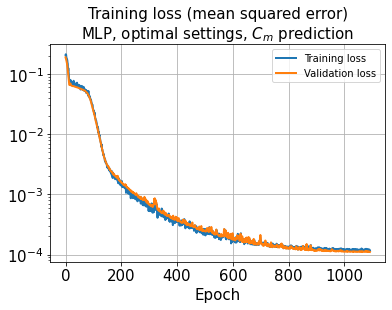

In [31]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nMLP, optimal settings, $C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

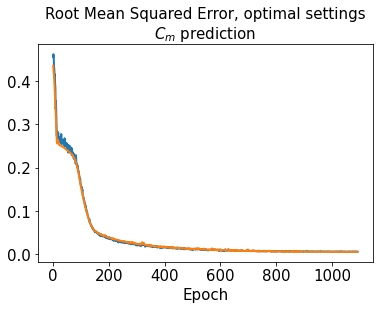

In [32]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

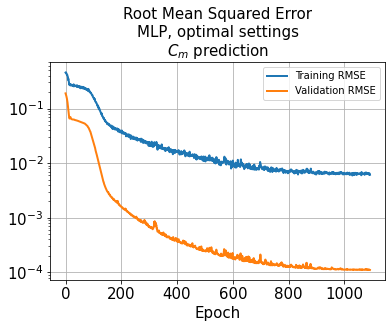

In [33]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nMLP, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [34]:
train_results = model.evaluate(x_train, y_train)

22/22 [==============================] - 0s 4ms/step - loss: 1.2243e-04 - rmse: 0.0064


In [35]:
val_results = model.evaluate(x_val, y_val)

7/7 [==============================] - 0s 4ms/step - loss: 1.1533e-04 - rmse: 0.0059


In [36]:
test_results = model.evaluate(x_test, y_test)

4/4 [==============================] - 0s 4ms/step - loss: 1.1186e-04 - rmse: 0.0056


In [37]:
decoded_train_ = model.predict(x_train)
decoded_val_ = model.predict(x_val)
decoded_test_ = model.predict(x_test)

4/4 [==============================] - 0s 2ms/step


In [38]:
def define_index(cm, y):
    return np.unique(np.where(np.isin(cm, y)))

In [39]:
def error_absolute(y_pred, y_true):
    return np.abs(y_pred - y_true)

In [40]:
# Denormalize 
def denormalize(y):
    return y*(np.max(cm)-np.min(cm))+np.min(cm)

In [41]:
def l2_error(y_pred, y_real):
    return np.sqrt(np.sum((y_pred - y_real)**2) / np.sum(y_real**2))

def mape(y_pred, y_real):
    return 100/len(y_real)*np.sum(np.abs((y_real-y_pred)/y_real))

def smape(y_pred, y_real):
    return 100*np.sum(np.abs(y_pred-y_real))/np.sum(y_real+y_pred)

In [42]:
index_train = define_index(y, y_train)
index_val = define_index(y, y_val)
index_test = define_index(y, y_test)

In [43]:
l2_error_train = l2_error(decoded_train_, y_train)
mape_train = smape(decoded_train_, y_train)
print(l2_error_train)
print(mape_train)

0.01376960168429242
0.5421342611099593


In [44]:
l2_error_val = l2_error(decoded_val_, y_val)
mape_val= smape(decoded_val_, y_val)
print(l2_error_val)
print(mape_val)

0.013185247127814553
0.5138928634671633


In [45]:
l2_error_test = l2_error(decoded_test_, y_test)
mape_test= smape(decoded_test_, y_test)
print(l2_error_test)
print(mape_test)

0.012088680638002041
0.4761567468207769


In [46]:
y_train = denormalize(y_train)
y_val = denormalize(y_val)
y_test = denormalize(y_test)

In [47]:
decoded_train = denormalize(decoded_train_)
decoded_val = denormalize(decoded_val_)
decoded_test = denormalize(decoded_test_)

In [48]:
model_directory = "D:\\TrainedModels\\20221230"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221230unsteadyValidation_MLP_Case13_WithoutParameters_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_layers) +"layers_"+str(n_units)+"units_CmPrediction.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [49]:
error_train_abs = error_absolute(decoded_train, y_train)
error_val_abs = error_absolute(decoded_val, y_val)
error_test_abs = error_absolute(decoded_test, y_test)

In [50]:
os.chdir(storage_dir)

In [51]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = l2_error(decoded_train[i], y_train[i])
    l2_error_train_list.append(l2_error_train_data)

In [52]:
l2_error_val_list = []
for i in range(0, len(x_val)):
    l2_error_val_data = l2_error(decoded_val[i], y_val[i])
    l2_error_val_list.append(l2_error_val_data)

In [53]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = l2_error(decoded_test[i], y_test[i])
    l2_error_test_list.append(l2_error_test_data)

In [54]:
mape_train_list = []
for i in range(0, len(x_train)):
    mape_train_data = smape(decoded_train[i], y_train[i])
    mape_train_list.append(mape_train_data)

In [55]:
mape_val_list = []
for i in range(0, len(x_val)):
    mape_val_data = smape(decoded_val[i], y_val[i])
    mape_val_list.append(mape_val_data)

In [56]:
mape_test_list = []
for i in range(0, len(x_test)):
    mape_test_data = smape(decoded_test[i], y_test[i])
    mape_test_list.append(mape_test_data)

In [57]:
def distribution_plot(y_pred, y_real, dataset="train"):
    dictionary_name = {"train":"training", "val":"validation", "test":"test"}
    dictionary_data = {"train":l2_error_train_list, "val":l2_error_val_list, "test":l2_error_test_list}
    dictionary_error = {"train":l2_error_train, "val":l2_error_val, "test":l2_error_test}
    plot_title = '$L_2$ error norm distribution - MLP, unsteady, '+ dictionary_name.get(dataset) +'.\nValidation rate {0}, test rate {1}, {2} layers, {3} units ($C_m$)'.format(
        val_rate, test_rate, n_layers, n_units)
    plt.plot(np.linspace(1,y_real.shape[0],y_real.shape[0]),
             dictionary_error.get(dataset)*np.ones(y_real.shape[0],), 'k', lw=2.5)
    plt.scatter(np.linspace(1, y_real.shape[0], y_real.shape[0]), dictionary_data.get(dataset), c='b')
    plt.xlabel('Index', fontsize=15)
    plt.ylabel('$L_2$ error norm', fontsize=15)
    plt.yscale('log')
    plt.title(plot_title, fontsize=15)
    plt.grid()

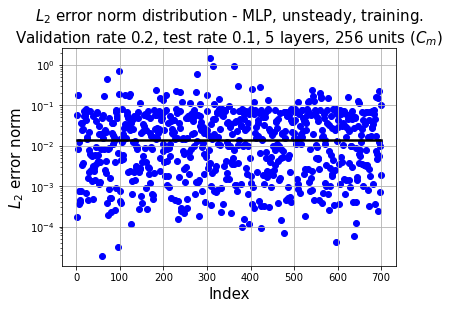

In [58]:
distribution_plot(decoded_train, y_train, dataset="train")
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

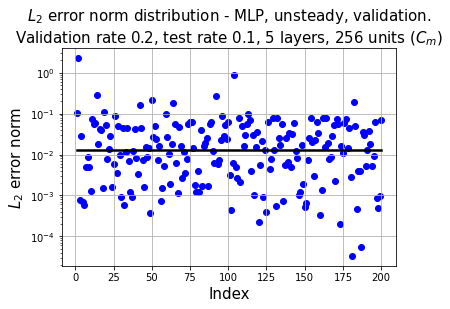

In [59]:
distribution_plot(decoded_val, y_val, dataset="val")
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

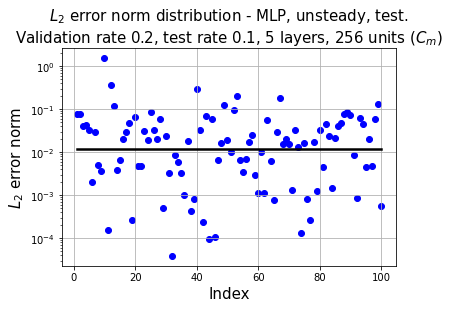

In [60]:
distribution_plot(decoded_test, y_test, dataset="test")
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [61]:
predicted = model.predict(x)

32/32 [==============================] - 0s 2ms/step


In [62]:
tTrain = t[index_train]+10
tVal = t[index_val]+10
tTest = t[index_test]+10

In [63]:
index_train.shape

(701,)

In [64]:
max(predicted)

array([0.9997666], dtype=float32)

In [66]:
l2_error(predicted, y)

0.013505124096231176

In [67]:
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for k , index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [68]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [69]:
def Cm_trainTestSplit_Plot(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm), 'k--', label='Predicted value')
    plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
    plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
    plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    plt.ylim([-0.05, 0.22])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

In [70]:
x[:,0] *= 5
x[:,0] += 10

L2 error of Cm: 0.0135


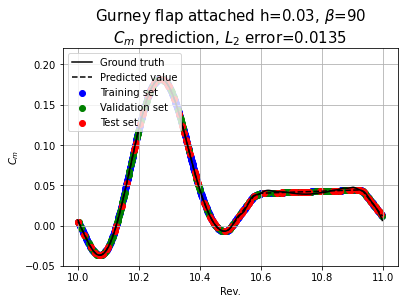

In [71]:
h = [0.03]
beta = [90]
for i in range(0,1):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

In [72]:
def Cm_trainTestSplit_Plot2(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm), 'b--', label='Predicted value')
#     plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
#     plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
#     plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

L2 error of Cm: 0.0135


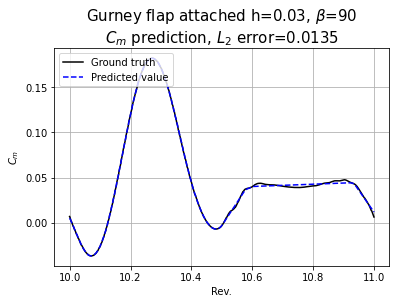

In [73]:
for i in range(0,1):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot2(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

L2 error of Cm: 0.0135


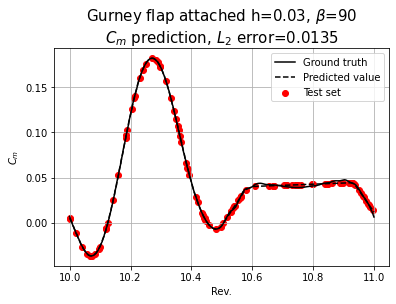

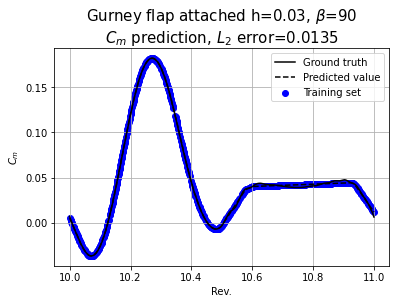

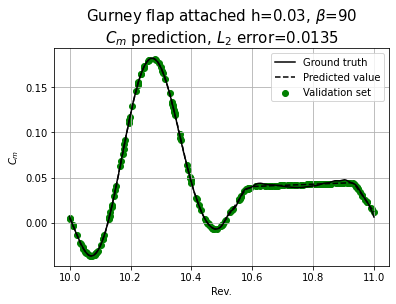

In [76]:
for i in range(0,1):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    title_Cm = title_n_Cm
    savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"

    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
#     Cm_trainTestSplit_Plot2(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

    # CD graph plot
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm_), 'k--', label='Predicted value')
    #plt.scatter(tTrain, iTrain, color='b', label='Training set')
    #plt.scatter(tVal, iVal, color='g', label='Validation set')
    plt.scatter(tTest, denormalize(iTest_), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm_), 'k--', label='Predicted value')
    plt.scatter(tTrain, denormalize(iTrain_), color='b', label='Training set')
    #plt.scatter(tVal, iVal, color='g', label='Validation set')
#     plt.scatter(tTest, denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm_), 'k--', label='Predicted value')
    #plt.scatter(tTrain, iTrain, color='b', label='Training set')
    plt.scatter(tVal, denormalize(iVal_), color='g', label='Validation set')
#     plt.scatter(tTest, denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()